## 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import xgboost as xgb

## 1. Set Up Constants

In [2]:
TEST_SIZE = 0.2
SEQUENCE_LENGTH = 14
RANDOM_STATE_SEED = 42

RSI_ROLLING_WINDOW_SIZE = 14

XGB_TEST_SIZE = 0.3
XGB_N_ESTIMATORS = 80
XGB_MAX_DEPTH = 3
XGB_LEARNING_RATE = 0.05
XGB_COLSAMPLE_BYTREE = 1.0
XGB_MIN_CHILD_WEIGHT = 5
XGB_SUBSAMPLE = 0.6

## 2. Original S&P 500 Dataset

In [3]:
"""
Assume that today is 2nd Jan 2025 and it is before market opening in the S&P500:

 - ARIMA: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today

 - GRU: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today

But i need to wait for market closing of 2nd Jan 2025 to obtain the actual results of the S&P500 prices,
so that I can calculate the prediction error of both models.

With prediction errors of 2nd Jan and actual S&P 500 price of 2nd Jan, i can predict price of tomorrow (3rd Jan)

 - XGB: 
    --> Price data of yesterday (1st Jan) to predict via ARIMA and GRU
    --> Obtain prediction error by today (2nd Jan)
    --> Using both prediction error (2nd Jan) and price data (2nd Jan) to predict tomorrow (3rd Jan)
"""

'\nAssume that today is 2nd Jan 2025 and it is before market opening in the S&P500:\n\n - ARIMA: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today\n\n - GRU: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today\n\nBut i need to wait for market closing of 2nd Jan 2025 to obtain the actual results of the S&P500 prices,\nso that I can calculate the prediction error of both models.\n\nWith prediction errors of 2nd Jan and actual S&P 500 price of 2nd Jan, i can predict price of tomorrow (3rd Jan)\n\n - XGB: \n    --> Price data of yesterday (1st Jan) to predict via ARIMA and GRU\n    --> Obtain prediction error by today (2nd Jan)\n    --> Using both prediction error (2nd Jan) and price data (2nd Jan) to predict tomorrow (3rd Jan)\n'

#### Read Datset

In [4]:
file_name = "SP500_forMacro.csv"

folder_name = "data"

folder_path = os.path.join(os.getcwd(), folder_name)

if os.path.isdir(folder_path):
    
    dataset_file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(dataset_file_path, index_col=False)
    
    print(f"Dataset has been read from {dataset_file_path}.")

else:
    print(f"Folder {folder_name} is not found at {folder_path}.")

Dataset has been read from c:\Users\ADMIN\OneDrive\SHARED FILES\D3 Sem1\Advanced Machine Learning\Project\data\SP500_forMacro.csv.


#### Processing Original SP500 Dataset to Obtain Alligned Data with Errors

In [5]:
# Fill Missing Values

df['SP500'] = df['SP500'].ffill()

In [6]:
# Set Index as Observation Date

df['observation_date'] = pd.to_datetime(df['observation_date'])

df.set_index('observation_date', inplace=True)

In [7]:
df.head()

,SP500
observation_date,
2018-04-02,2581.88
2018-04-03,2614.45
2018-04-04,2644.69
2018-04-05,2662.84
2018-04-06,2604.47


In [8]:
# Dropout first 13 days of data due to missing data from GRU features (SMI)

df = df.iloc[(RSI_ROLLING_WINDOW_SIZE-1):]

In [9]:
df.head()

,SP500
observation_date,
2018-04-19,2693.13
2018-04-20,2670.14
2018-04-23,2670.29
2018-04-24,2634.56
2018-04-25,2639.40


In [10]:
# Columns = 'SP500'
y = df['SP500']

X = df.copy(deep=True)

In [11]:
## Train test split was done to find length of test dataset which is what we need

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE_SEED, 
                                                    shuffle=False)

In [12]:
print(f"Length of X_train: {len(X_train)}")
print(f"Lenth of y_train: {len(y_train)}")

print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 1501
Lenth of y_train: 1501
Length of X_test: 376
Length of y_test: 376


In [13]:
def create_sequence(X_df, y_df, seq_length):
    new_X = []

    new_y = []
    
    for i in range(0, (len(y_df) - seq_length)):

        temp_X = None

        # If it is a DataFrame, index it in 2-dimensions
        if isinstance(X_df, pd.DataFrame):
            temp_X = X_df.iloc[i:(i+seq_length), :]

        else:
            temp_X = X_df.iloc[i:(i+seq_length)]

        temp_y = y_df.iloc[i+seq_length]

        temp_X = np.squeeze(temp_X.values)

        new_X.append(temp_X.tolist())

        new_y.append(temp_y)
    
    return new_X, new_y

In [14]:
X_test, y_test = create_sequence(X_test, y_test,
                                 seq_length=SEQUENCE_LENGTH)

In [15]:
print(f"Number of sequences of y_test: {len(y_test)}")

print(f"Size of y_test: [{len(y_test)}, 1]")

Number of sequences of y_test: 362
Size of y_test: [362, 1]


#### Conversion into Pandas DataFrame

In [16]:
y_test_dict = {'SP500': y_test}

y_test_pd = pd.DataFrame(y_test_dict)

In [17]:
y_test_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   362 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [18]:
print(y_test_pd)

       SP500
0    4997.91
1    5026.61
2    5021.84
3    4953.17
4    5000.62
..       ...
357  6025.17
358  6092.18
359  6092.16
360  6141.02
361  6173.07

[362 rows x 1 columns]


## 3. GRU and ARIMA Prediction Error Files

#### Read Saved Prediction Errors CSV

In [19]:
folder_name = 'processed_data'

gru_error_filename = "gru_error.csv"
arima_error_filename = "arima_error.csv"

gru_error_filepath = os.path.join(os.getcwd(), folder_name, gru_error_filename)
arima_error_filepath = os.path.join(os.getcwd(), folder_name, arima_error_filename)

In [20]:
if os.path.exists(gru_error_filepath):
    gru_error_pd = pd.read_csv(gru_error_filepath, index_col=False)

    print(f"GRU prediction error file successfully read from:\n{gru_error_filepath}\n")
else:
    print(f"ERROR: GRU prediction error file does not exists at:\n{gru_error_filepath}\n")

if os.path.exists(arima_error_filepath):
    arima_error_pd = pd.read_csv(arima_error_filepath, index_col=False)

    print(f"ARIMA prediction error file successfully read from:\n{arima_error_filepath}\n")
else:
    print(f"ERROR: ARIMA prediction error file does not exists at:\n{arima_error_filepath}\n")

GRU prediction error file successfully read from:
c:\Users\ADMIN\OneDrive\SHARED FILES\D3 Sem1\Advanced Machine Learning\Project\processed_data\gru_error.csv

ARIMA prediction error file successfully read from:
c:\Users\ADMIN\OneDrive\SHARED FILES\D3 Sem1\Advanced Machine Learning\Project\processed_data\arima_error.csv



#### Datasets Information

In [21]:
arima_error_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Arima Error  362 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [22]:
gru_error_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GRU Error  362 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [23]:
print(arima_error_pd)

     Arima Error
0      14.296823
1      38.625762
2      -9.534774
3     -59.204815
4      28.509477
..           ...
357    60.866389
358    68.442146
359   -21.346500
360    54.140363
361    37.333848

[362 rows x 1 columns]


In [24]:
print(gru_error_pd)

      GRU Error
0      0.513516
1     30.852188
2     -4.984707
3    -64.679121
4     51.232305
..          ...
357  102.401934
358  108.375801
359   56.831875
360  111.999980
361   93.060723

[362 rows x 1 columns]


## 4. Data Pre-Processing

#### Combine Both Model Prediction Errors

In [25]:
error_df = pd.concat([y_test_pd, arima_error_pd, gru_error_pd],
                     axis=1,
                     ignore_index=True)

error_df = error_df.rename({0: "SP500", 
                            1: "ARIMA Error", 
                            2: "GRU Error"},
                            axis=1)

In [26]:
error_df.head()

,SP500,ARIMA Error,GRU Error
0,4997.91,14.296823,0.513516
1,5026.61,38.625762,30.852188
2,5021.84,-9.534774,-4.984707
3,4953.17,-59.204815,-64.679121
4,5000.62,28.509477,51.232305


In [27]:
error_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SP500        362 non-null    float64
 1   ARIMA Error  362 non-null    float64
 2   GRU Error    362 non-null    float64
dtypes: float64(3)
memory usage: 8.6 KB


In [28]:
error_df.describe()

,SP500,ARIMA Error,GRU Error
count,362.000000,362.000000,362.000000
mean,5608.810304,20.174441,32.856977
std,338.549480,315.340101,61.489857
min,4953.170000,-337.107959,-288.575273
25%,5305.050000,-24.022133,0.879233
50%,5628.620000,6.403403,33.823984
75%,5918.250000,35.707442,65.335386
max,6173.070000,5892.580000,467.504492


In [29]:
error_df.isnull().sum()

SP500          0
ARIMA Error    0
GRU Error      0
dtype: int64

In [30]:
print(error_df)

       SP500  ARIMA Error   GRU Error
0    4997.91    14.296823    0.513516
1    5026.61    38.625762   30.852188
2    5021.84    -9.534774   -4.984707
3    4953.17   -59.204815  -64.679121
4    5000.62    28.509477   51.232305
..       ...          ...         ...
357  6025.17    60.866389  102.401934
358  6092.18    68.442146  108.375801
359  6092.16   -21.346500   56.831875
360  6141.02    54.140363  111.999980
361  6173.07    37.333848   93.060723

[362 rows x 3 columns]


#### Dataset Sequencing

In [31]:
y = error_df['SP500']

# Predict next days data
X_xgb, y_xgb = create_sequence(error_df, y,
                             seq_length=1)

In [32]:
print(X_xgb[:5])

[[4997.91, 14.296822507599243, 0.5135156249998545], [5026.61, 38.62576201246338, 30.852187500000586], [5021.84, -9.53477370590008, -4.984707031249855], [4953.17, -59.20481540977926, -64.67912109374993], [5000.62, 28.50947656984408, 51.23230468749989]]


In [33]:
print(y_xgb[:5])

[np.float64(5026.61), np.float64(5021.84), np.float64(4953.17), np.float64(5000.62), np.float64(5029.73)]


In [34]:
print(f"Length of X: {len(X_xgb)}")
print(f"Length of y: {len(y_xgb)}")

Length of X: 361
Length of y: 361


#### Dataset Train Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_xgb, y_xgb,
                                                    test_size=XGB_TEST_SIZE, 
                                                    random_state=RANDOM_STATE_SEED)

In [36]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [37]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}\n")

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (252, 3)
Shape of y_train: (252, 1)

Shape of X_test: (109, 3)
Shape of y_test: (109, 1)


In [38]:
print(X_train)

[[ 5.85985000e+03  6.08738343e+01  8.28993164e+01]
 [ 6.11463000e+03  1.51539127e+01  5.67501172e+01]
 [ 6.08419000e+03  5.06167763e+01  9.45122656e+01]
 [ 5.61456000e+03 -1.34275969e+02 -1.21784238e+02]
 [ 5.10476000e+03  3.15196494e+01  3.25539453e+01]
 [ 5.63128000e+03  7.68845388e+00  4.65226758e+01]
 [ 5.26695000e+03 -3.52478287e+01 -3.34542969e+01]
 [ 5.97084000e+03 -6.42267931e+01 -3.60140625e+00]
 [ 5.07865000e+03 -5.29793099e+01 -4.49427734e+01]
 [ 5.84972000e+03 -1.07193351e+02 -7.36447461e+01]
 [ 5.53702000e+03  3.03007287e+01  4.67714648e+01]
 [ 5.67512000e+03  5.54614148e+01  5.97786914e+01]
 [ 5.55574000e+03 -1.91548801e+01  2.84546875e+00]
 [ 5.23418000e+03 -3.01202569e+00  6.87238281e+00]
 [ 5.25435000e+03  6.34697889e+00  1.19281250e+01]
 [ 5.59576000e+03  4.39621165e+01  6.28898828e+01]
 [ 5.84147000e+03 -1.92264259e+00  3.60134570e+01]
 [ 5.74537000e+03  3.70110685e+01  5.45096484e+01]
 [ 6.11507000e+03  6.45157636e+01  1.24575371e+02]
 [ 5.47105000e+03  5.88623174e+

In [39]:
print(y_train)

[[5815.26]
 [6114.63]
 [6051.25]
 [5572.07]
 [5157.36]
 [5663.94]
 [5235.48]
 [5906.94]
 [5104.76]
 [5778.15]
 [5537.02]
 [5614.66]
 [5427.13]
 [5218.19]
 [5243.77]
 [5626.02]
 [5864.67]
 [5738.17]
 [6114.63]
 [5495.52]
 [5062.25]
 [5751.13]
 [5064.2 ]
 [5631.22]
 [5648.4 ]
 [5005.57]
 [6068.5 ]
 [5937.34]
 [5088.8 ]
 [5708.75]
 [5537.02]
 [5283.4 ]
 [5675.12]
 [6049.24]
 [5853.98]
 [5808.12]
 [5996.66]
 [5983.99]
 [5487.03]
 [5297.1 ]
 [5659.91]
 [5447.87]
 [5592.18]
 [5954.5 ]
 [5469.3 ]
 [5985.38]
 [5308.15]
 [5165.31]
 [5205.81]
 [5591.96]
 [5436.44]
 [5246.68]
 [5569.06]
 [5872.16]
 [5675.29]
 [6037.59]
 [5346.56]
 [5648.4 ]
 [5917.11]
 [5360.79]
 [5268.05]
 [5484.77]
 [5363.36]
 [5892.58]
 [5861.57]
 [5859.85]
 [5970.81]
 [5797.42]
 [5994.57]
 [5319.31]
 [5211.49]
 [5069.53]
 [5909.03]
 [5929.04]
 [5667.2 ]
 [5841.47]
 [5662.89]
 [5930.85]
 [5555.74]
 [5844.61]
 [6038.81]
 [6066.44]
 [5886.55]
 [5745.37]
 [6039.31]
 [6086.37]
 [5595.76]
 [6101.24]
 [4953.17]
 [5505.  ]
 [5916.98]

## 5. XGBoost Model

#### XGBoost Model Setup

In [40]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = XGB_N_ESTIMATORS, 
                             max_depth = XGB_MAX_DEPTH,
                             learning_rate = XGB_LEARNING_RATE,
                             colsample_bytree = XGB_COLSAMPLE_BYTREE,
                             min_child_weight = XGB_MIN_CHILD_WEIGHT,
                             subsample = XGB_SUBSAMPLE,
                             random_state = RANDOM_STATE_SEED,
                             tree_method='hist',
                             enable_categorical=False)

#### Model Fitting

In [41]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=80,
             n_jobs=None, num_parallel_tree=None, ...)

#### Model Evaluation

In [42]:
y_pred = xgb_model.predict(X_test)

rmse_value = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse_value:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 71.227
R²: 0.956


#### Hyperparameter Grid Search

In [43]:
param_grid = {
    'n_estimators': [80, 100, 120, 150, 200],
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=3)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 80, 'subsample': 0.6}


In [44]:
y_pred = grid_search.predict(X_test)

rmse_value = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE of Best Params: {rmse_value:.3f}')
print(f'R² of Best Params: {r2:.3f}')

RMSE of Best Params: 71.227
R² of Best Params: 0.956


#### Feature Importance

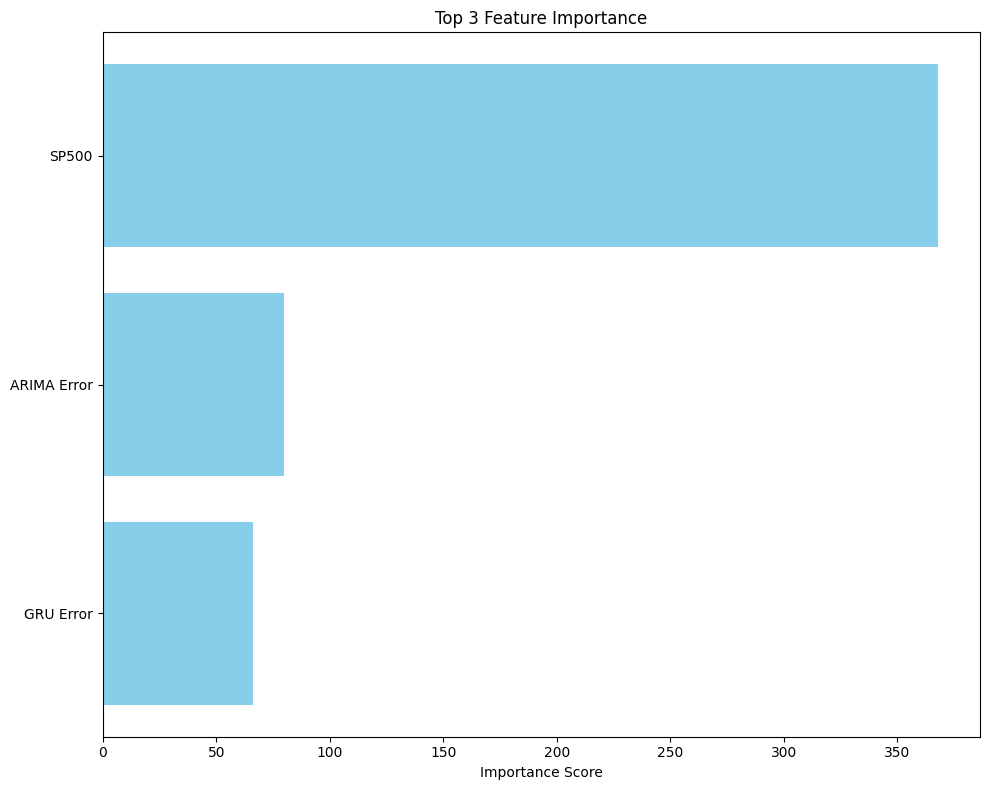

In [45]:
importance = xgb_model.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame({
    'Feature': error_df.columns.to_list(),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

top_n = 3
plt.figure(figsize=(10, 8))
plt.barh(
    importance_df['Feature'].head(top_n)[::-1],
    importance_df['Importance'].head(top_n)[::-1],
    color='skyblue'
)
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importance')
plt.tight_layout()
plt.show()

#### Graph of Actual vs Prediction Values

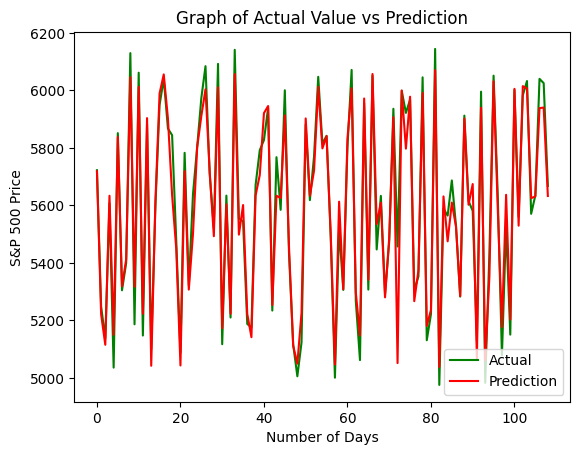

In [47]:
plt.plot(y_test, label="Actual", color='green')
plt.plot(y_pred, label="Prediction", color='red')

plt.title("Graph of Actual Value vs Prediction")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Model Residuals (Testing)

In [48]:
print(len(y_test))

109


In [49]:
print(len(y_pred))

109


In [50]:
residuals = np.squeeze(np.array(y_test)) - np.array(y_pred)

In [51]:
for i in range(0, len(residuals)):
    residuals[i] = abs(residuals[i])

In [52]:
residuals_df = pd.DataFrame(residuals)

In [53]:
residuals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       109 non-null    float64
dtypes: float64(1)
memory usage: 1004.0 bytes


In [54]:
residuals_df.describe()

,0
count,109.000000
mean,49.954245
std,51.007411
min,0.791738
25%,16.506348
50%,35.493242
75%,75.895469
max,405.499121


<Axes: title={'center': 'Residual Graph of XGBoost During Testing'}>

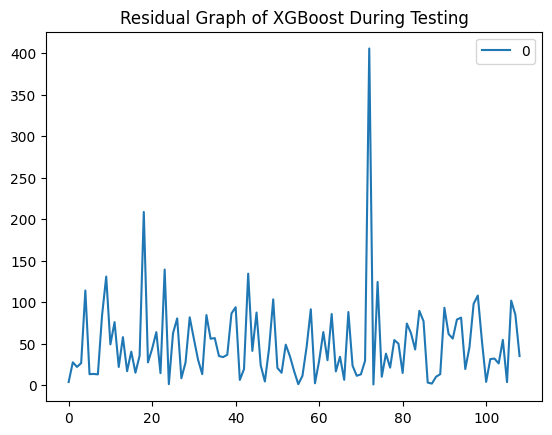

In [55]:
residuals_df.plot(title="Residual Graph of XGBoost During Testing")

<Axes: title={'center': 'Residual Density Graph'}, ylabel='Density'>

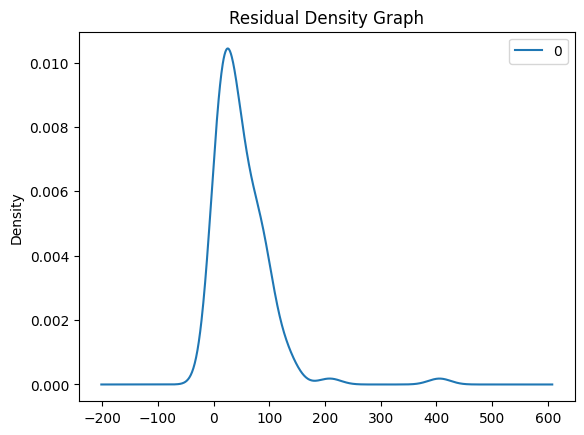

In [56]:
residuals_df.plot(kind='kde', title="Residual Density Graph")

## 6. Graph of Combined Results

#### Calculate ARIMA and GRU Prediction Values

In [57]:
"""
y_train list --> 
 - Col 0: SP500
 - Col 1: ARIMA Error
 - Col 2: GRU Error

Eliminate first row of data due to missing first row prediction after combining via XGBoost
"""

gru_pred_lst = np.array(X_train[1:, 0]) - np.array(X_train[1:, 2])
arima_pred_lst = np.array(X_train[1:, 0]) - np.array(X_train[1:, 1])

In [58]:
print(f"Length of GRU prediction: {len(gru_pred_lst)}\n")

print(gru_pred_lst[:5])

Length of GRU prediction: 251

[6057.87988281 5989.67773438 5736.34423828 5072.20605469 5584.75732422]


In [59]:
print(f"Length of ARIMA prediction: {len(arima_pred_lst)}\n")

print(arima_pred_lst[:5])

Length of ARIMA prediction: 251

[6099.47608731 6033.57322368 5748.83596878 5073.24035058 5623.59154612]


#### Conversion of Variables

In [60]:
print(y_test[:5])

[[5722.26]
 [5248.49]
 [5137.08]
 [5606.91]
 [5035.69]]


In [61]:
new_y_test = [x[0].item() for x in y_test]

In [62]:
print(y_test[:5])

[[5722.26]
 [5248.49]
 [5137.08]
 [5606.91]
 [5035.69]]


#### Plotting Actual vs Prediction of XGBoost Only

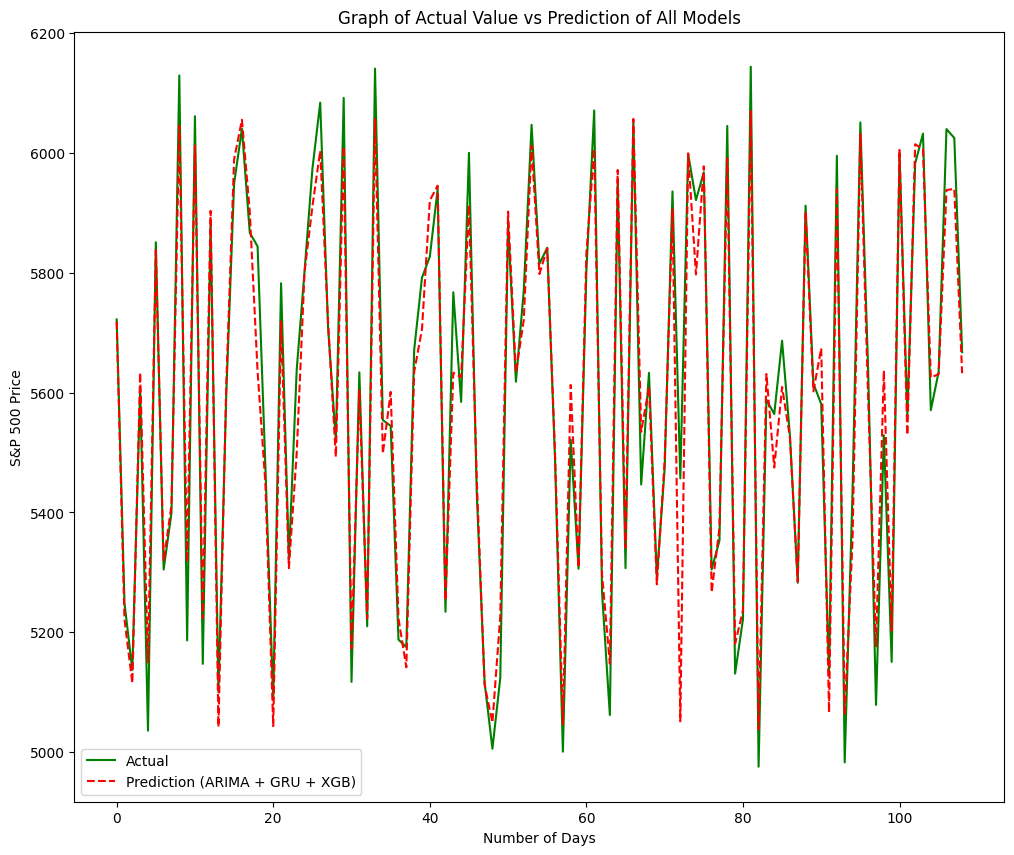

In [63]:
fig = plt.figure(figsize=(12, 10))

plt.plot(y_test, label="Actual", color='green')
plt.plot(y_pred, label="Prediction (ARIMA + GRU + XGB)", linestyle='dashed', color='red')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Plotting Actual vs Prediction of ARIMA and GRU

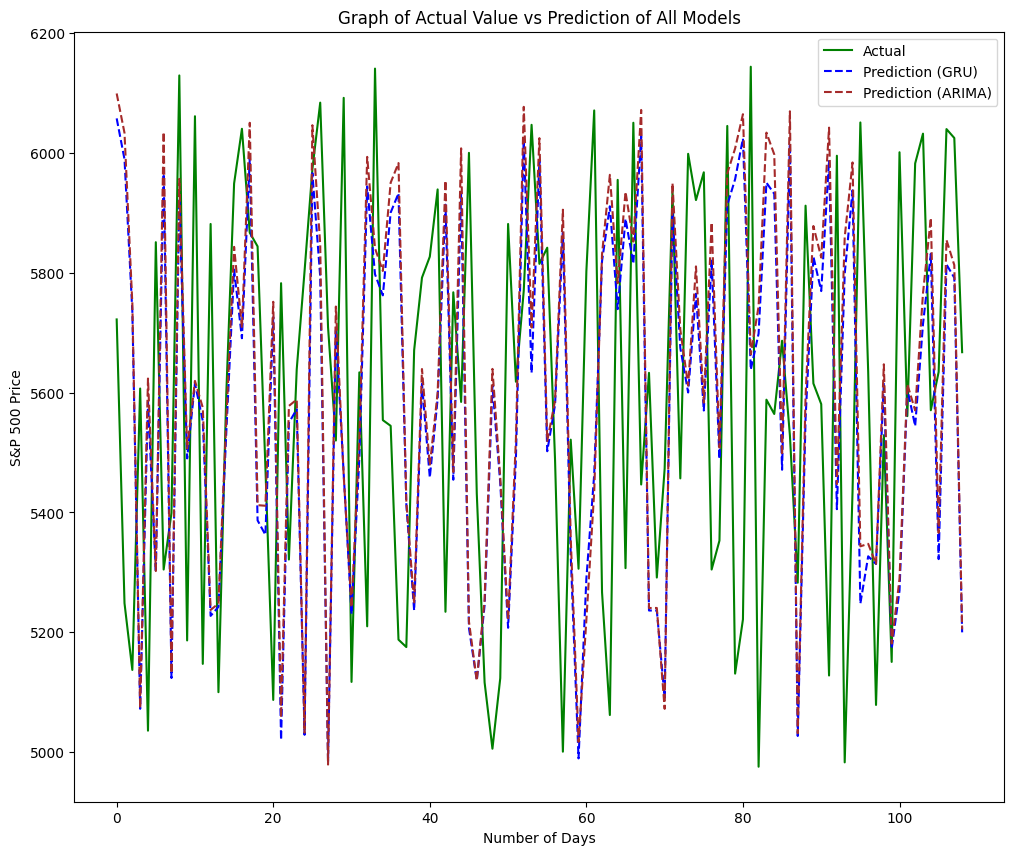

In [69]:
fig = plt.figure(figsize=(12, 10))

plt.plot(y_test, label="Actual", color='green')

plt.plot(gru_pred_lst[:len(y_test)], label="Prediction (GRU)", linestyle='dashed', color='blue')
plt.plot(arima_pred_lst[:len(y_test)], label="Prediction (ARIMA)", linestyle='dashed', color='brown')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Plotting Actual vs Prediction of All Models

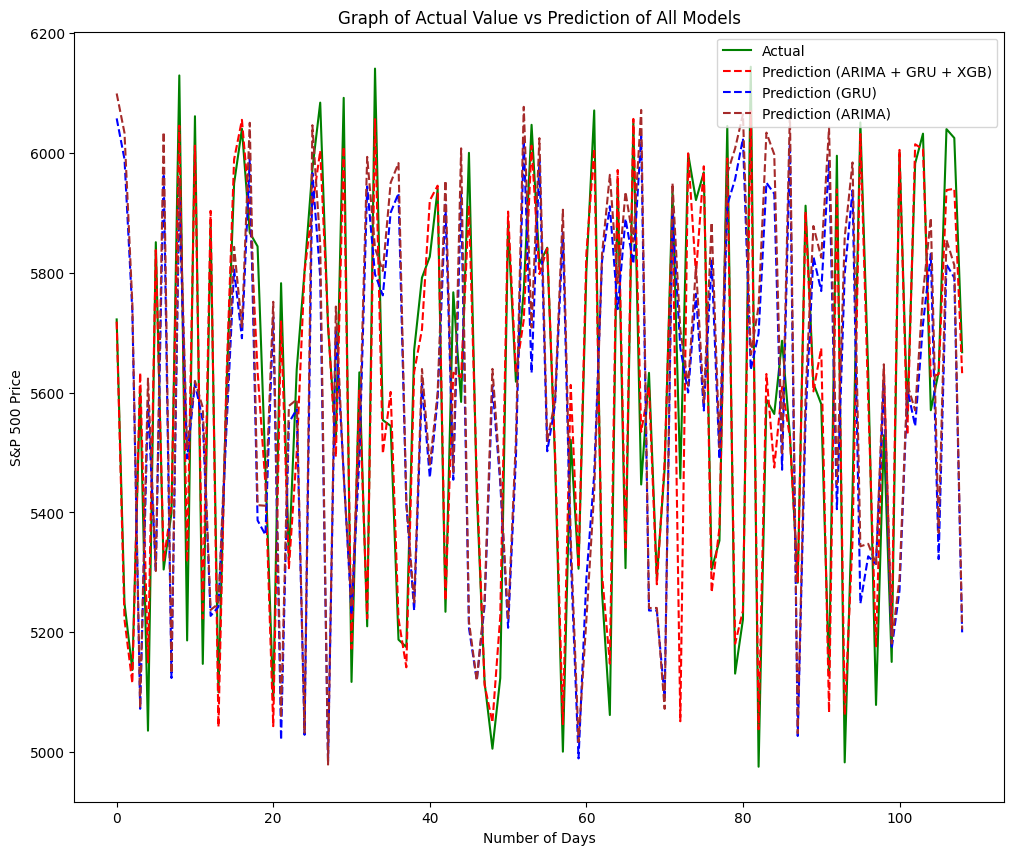

In [68]:
fig = plt.figure(figsize=(12, 10))

plt.plot(y_test, label="Actual", color='green')
plt.plot(y_pred, label="Prediction (ARIMA + GRU + XGB)", linestyle='dashed', color='red')

plt.plot(gru_pred_lst[:len(y_test)], label="Prediction (GRU)", linestyle='dashed', color='blue')
plt.plot(arima_pred_lst[:len(y_test)], label="Prediction (ARIMA)", linestyle='dashed', color='brown')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()